# Datamining Mini Project: Flight Prices Prediction
### Dipartimento di Fisica, UniTo
##### Carola Maria Caivano, 867290
##### Andrei Stelian Potra, 857665

# Abstract
In questo progetto lo scopo è quello di predire i prezzi dei voli aerei utilizzando un dataset relativo a centinaia di migliaia di tragitti di compagnie aeree indiane. Questo dataset è stato utilizzato da un altro team precedentemente per lo stesso scopo utilizzando modelli di machine learning classici ensembled (https://www.kaggle.com/code/julienjta/flight-price-prediction-98-47-r2-score).
L'obbiettivo di questo progetto invece è utilizzare una rete neurale fully connected per un task di regressione in modo da poter conseguire uno score migliore di:
- $ R^2 = 0.9847 $
- $ MAE = 1493 $

#### Indice
1. Impostazione dei dati
2. Studio delle features
  - 2.1 Media dei prezzi vs. giorni rimanenti
  - 2.2 Media dei prezzi vs. durata del volo
  - 2.3 Boxplot sulle Features categoriche
3. Preprocessing
  - 3.1 One-Hot Encoding
  - 3.2 Standard Scaling
  - 3.3 Estrazione dei target e conversione in array
  - 3.4 Creazione di dataset di training, validazione e di testing
4. Fully Connected Neural Network
  - 4.1 Run Singola del modello
  - 4.2 Risultati sul Test Set
  - 4.3 Plot degli score per diverse run singole (diversi iperparametri)
  - 4.4 Ottimizzazione automatica con Keras Tuner
5. Risultati Finali

# 1. Importazione dei dati
I dati a disposizione sono circa 300 mila voli labellati con i rispettivi prezzi. Si è deciso di condurre due studi in parallelo dove in uno si utilizza il dataset completo e in un altro il dataset con solo un terzo dei samples totali. Questo a causa dell'impossibilità di lavorare con risorse RAM sufficienti per tutti i dati sulla piattaforma kaggle dove è stato richiesto di eseguire tutto il notebook senza errori. Invece lo studio con tutti i dati è condotto in locale su un computer che dispone di tutta la RAM necessaria per processare tutti i dati senza errori.  
In questo notebook la rete viene addestrata usando perciò solo un terzo dei dati. Invece il modello addestrato su tutti i dati è stato salvato in locale ed è possibile importarlo.

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import pandas as pd
import numpy as np

# importing data and visualizing with pandas
data = pd.read_csv('../input/flight-price-prediction/Clean_Dataset.csv', encoding='utf8')
display(data)

/kaggle/input/test-set-alldata/df_X_test.csv
/kaggle/input/test-set-alldata/df_y_test.csv
/kaggle/input/flight-price-prediction/business.csv
/kaggle/input/flight-price-prediction/economy.csv
/kaggle/input/flight-price-prediction/Clean_Dataset.csv
/kaggle/input/valori-scores/Valori_score_normal.ods
/kaggle/input/valori-scores/Valori_score_lecun_uniform.ods
/kaggle/input/valori-scores/Valori_score_uniform.ods
/kaggle/input/best-model-full-data/model_lr02_bs2048_reg0.01/saved_model.pb
/kaggle/input/best-model-full-data/model_lr02_bs2048_reg0.01/keras_metadata.pb
/kaggle/input/best-model-full-data/model_lr02_bs2048_reg0.01/variables/variables.index
/kaggle/input/best-model-full-data/model_lr02_bs2048_reg0.01/variables/variables.data-00000-of-00001


,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955
...,...,...,...,...,...,...,...,...,...,...,...,...
300148,300148,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265
300149,300149,Vistara,UK-826,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105
300150,300150,Vistara,UK-832,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099
300151,300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585


In [2]:
from sklearn.utils import shuffle # for shuffling samples
df_shuffled = shuffle(data)

# number of rows to drop
n = 200000
 
# dropping last n rows using drop
df_shuffled.drop(df_shuffled.tail(n).index, inplace = True)

In [3]:
data = df_shuffled
#delete first column
data=data.drop(columns=['Unnamed: 0'])
display(data)

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
133618,Vistara,UK-778,Kolkata,Afternoon,one,Night,Mumbai,Economy,6.67,38,6731
32139,GO_FIRST,G8-119,Delhi,Evening,one,Morning,Hyderabad,Economy,13.83,27,5657
126172,Indigo,6E-6021,Kolkata,Afternoon,one,Evening,Delhi,Economy,6.00,42,2994
4170,Vistara,UK-813,Delhi,Evening,one,Night,Mumbai,Economy,5.83,22,6296
218547,Vistara,UK-981,Delhi,Night,one,Evening,Kolkata,Business,19.17,41,65529
...,...,...,...,...,...,...,...,...,...,...,...
205006,AirAsia,I5-517,Chennai,Morning,zero,Morning,Hyderabad,Economy,1.17,31,1105
58085,AirAsia,I5-336,Mumbai,Night,zero,Night,Bangalore,Economy,1.92,31,2124
155849,Indigo,6E-913,Hyderabad,Morning,one,Night,Delhi,Economy,11.00,29,6133
144552,Indigo,6E-379,Kolkata,Early_Morning,one,Morning,Hyderabad,Economy,5.25,20,5699


In [4]:
# importing data and visualizing with pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Studio delle Features
In questa sezione si vuole vedere quali features influenzano maggiormente il prezzo dei voli. Infatti si possono presentare delle features che singolarmente non hanno potere predittivo sul valore dei prezzi.

### 2.1 Media dei prezzi vs. giorni rimanenti

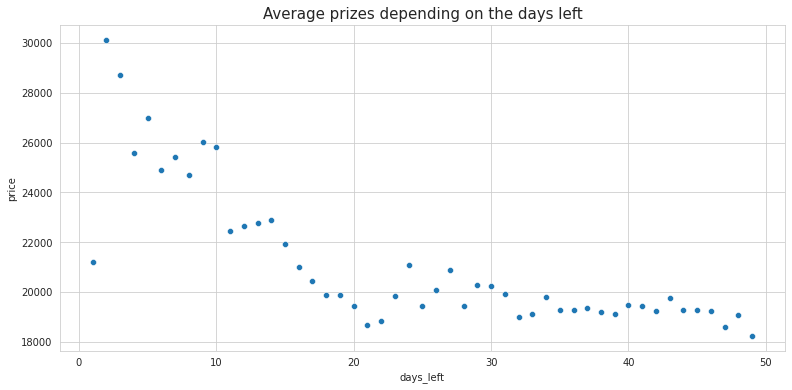

In [5]:
sns.set_style("whitegrid")
df_temp = data.groupby(['days_left'])['price'].mean().reset_index()

plt.figure(figsize=(13,6))
ax = sns.scatterplot(x="days_left", y="price", data=df_temp).set_title("Average prizes depending on the days left",fontsize=15)

È possibile osservare che il numero di giorni rimanenti alla partenza influenzi il prezzo, in particolare quando la data della partenza si avvicina i prezzi aumentano. Invece prima dei 20 giorni rimanenti la media dei prezzi ha una piccola variazione.  
Quindi la feature days_left ha sicuramente un'importanza nella predizione.

### 2.2 Media dei prezzi vs. durata del volo

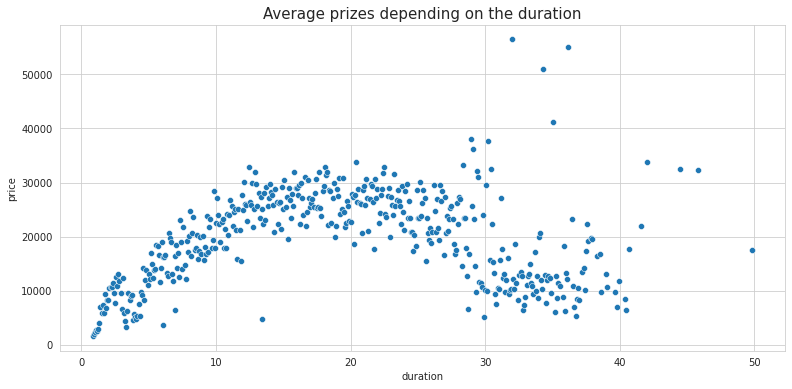

In [6]:
sns.set_style("whitegrid")

df_temp = data.groupby(['duration'])['price'].mean().reset_index()

plt.figure(figsize=(13,6))
ax = sns.scatterplot(x="duration", y="price", data=df_temp).set_title("Average prizes depending on the duration",fontsize=15)

Anche la durata del volo è una feature influente sul valore del prezzo.

## 2.3 Boxplot sulle Features categoriche
Per quanto riguarda le features categoriche, come per esempio la linea di volo, oppure la città di partenza, si possono realizzare dei boxplot per vedere la distribuzione dei prezzi e in base a quello riconoscere la presenza di un trend.

Text(0.5, 1.0, 'Airline prices based on the destination_city')

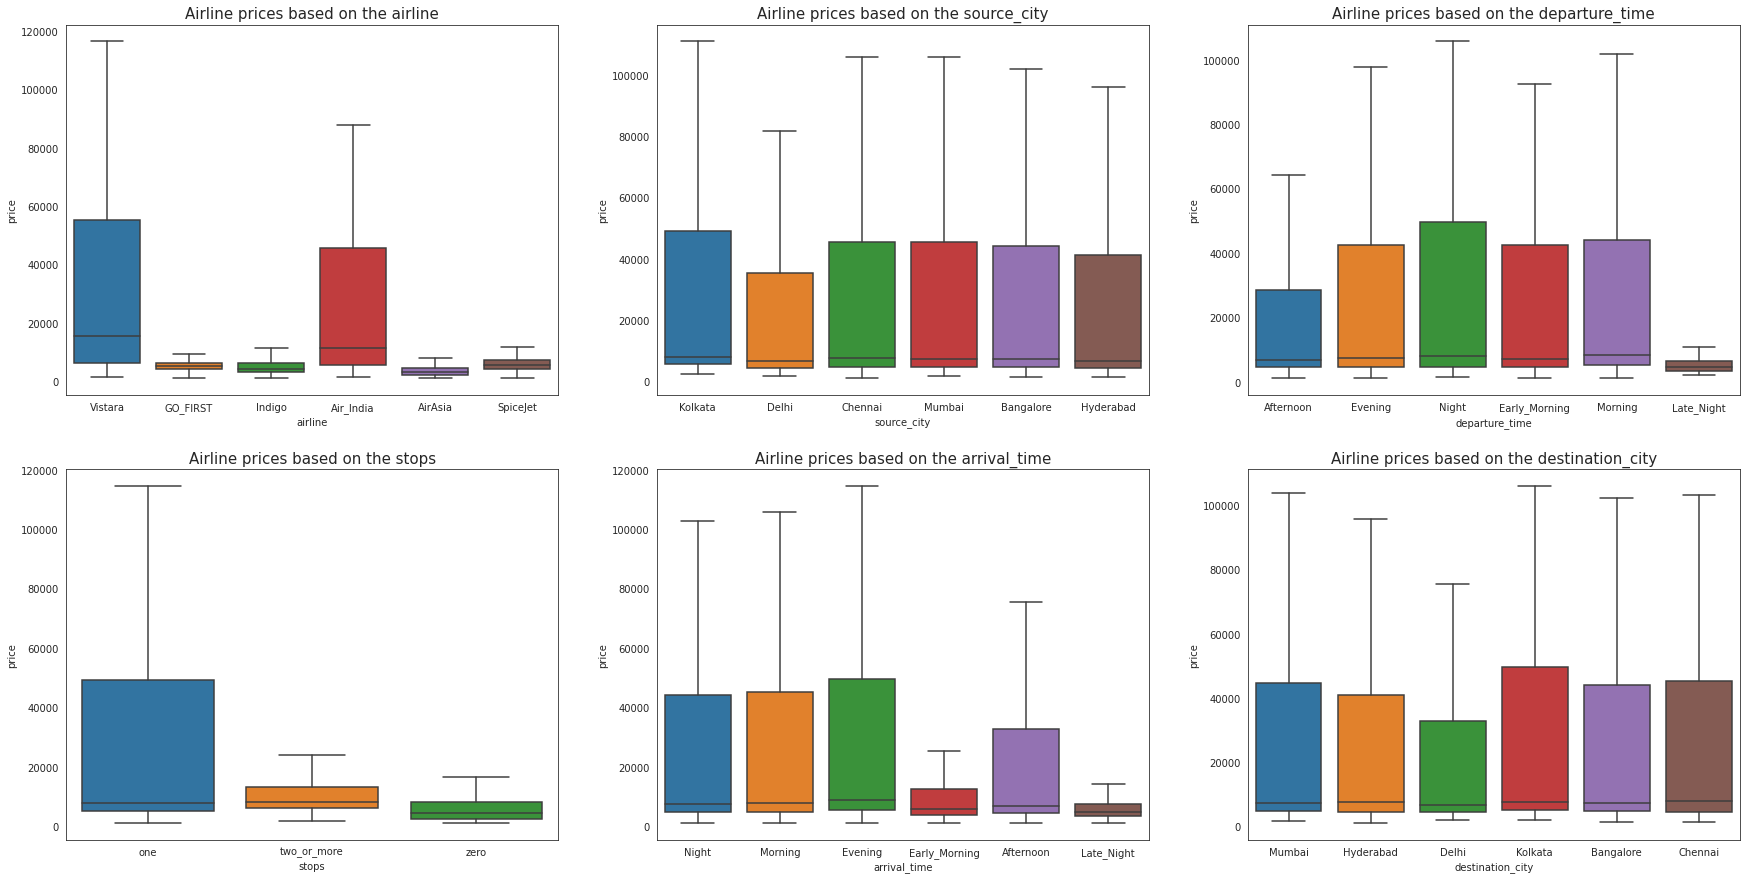

In [7]:
plt.figure(figsize=(30,15))

sns.set_style("white")
plt.subplot(2,3,1)
sns.boxplot(data=data, y=data['price'], x=data['airline'],showfliers=False).set_title("Airline prices based on the airline",fontsize=15)

sns.set_style("white")
plt.subplot(2,3,2)
sns.boxplot(data=data, y=data['price'], x=data['source_city'],showfliers=False).set_title("Airline prices based on the source_city",fontsize=15)

sns.set_style("white")
plt.subplot(2,3,3)
sns.boxplot(data=data, y=data['price'], x=data['departure_time'],showfliers=False).set_title("Airline prices based on the departure_time",fontsize=15)

sns.set_style("white")
plt.subplot(2,3,4)
sns.boxplot(data=data, y=data['price'], x=data['stops'],showfliers=False).set_title("Airline prices based on the stops",fontsize=15)

sns.set_style("white")
plt.subplot(2,3,5)
sns.boxplot(data=data, y=data['price'], x=data['arrival_time'],showfliers=False).set_title("Airline prices based on the arrival_time",fontsize=15)

sns.set_style("white")
plt.subplot(2,3,6)
sns.boxplot(data=data, y=data['price'], x=data['destination_city'],showfliers=False).set_title("Airline prices based on the destination_city",fontsize=15)

La feature airline (compagnia aerea) presenta due categorie con una distribuzione di prezzi molto più ampia delle altre poichè tali compagnie offrono la possibilità di comprare il biglietto in classe business.  
Le due features source_city e destination_city invece hanno i body dei boxplot con distribuzione quasi uniforme.  
Per quanto riguarda departure_time e arrival_time si osserva che alcune categorie danno una più ampia variabilità di prezzi possibili rispetto ad altre, per esempio i voli che partono in tarda notte hanno dei prezzi significativamente più bassi rispetto alle altre categorie.  
Anche gli stops influiscono, prendendo un volo con zero cambi il prezzo è minore rispetto ad un tragitto con un cambio.

# 3. Preprocessing
Il preprocessing di questo dataset è consistito nel one-hot encoding su tutte le features categoriche e in uno standard scaling delle features numeriche (days_left e duration).
### 3.1 One-Hot Encoding

In [8]:
print(data['source_city'].unique()) #città da cui partono gli aerei
print(data['airline'].unique())
print(data['flight'].unique())
print(data['departure_time'].unique())
print(data['stops'].unique())
print(data['arrival_time'].unique())
print(data['destination_city'].unique())
print(data['class'].unique())

['Kolkata' 'Delhi' 'Chennai' 'Mumbai' 'Bangalore' 'Hyderabad']
['Vistara' 'GO_FIRST' 'Indigo' 'Air_India' 'AirAsia' 'SpiceJet']
['UK-778' 'G8-119' '6E-6021' ... 'SG-1058' '6E-864' '6E-488']
['Afternoon' 'Evening' 'Night' 'Early_Morning' 'Morning' 'Late_Night']
['one' 'two_or_more' 'zero']
['Night' 'Morning' 'Evening' 'Early_Morning' 'Afternoon' 'Late_Night']
['Mumbai' 'Hyderabad' 'Delhi' 'Kolkata' 'Bangalore' 'Chennai']
['Economy' 'Business']


In [9]:
# riconosce il numero di categorie uniche presenti e fa one-hot encoding
dummy_source_city = pd.get_dummies(data['source_city'])
dummy_airline = pd.get_dummies(data['airline'])
dummy_flight = pd.get_dummies(data['flight'])
dummy_departure_time = pd.get_dummies(data['departure_time'])
dummy_stops = pd.get_dummies(data['stops'])
dummy_arrival_time = pd.get_dummies(data['arrival_time'])
dummy_destination_city = pd.get_dummies(data['destination_city'])
dummy_class = pd.get_dummies(data['class'])

In [10]:
display(dummy_source_city.iloc[32000: 32015]) #visualizzazione 15 valori

,Bangalore,Chennai,Delhi,Hyderabad,Kolkata,Mumbai
145748,0,0,0,0,1,0
175011,0,0,0,1,0,0
19797,0,0,1,0,0,0
110327,1,0,0,0,0,0
125847,0,0,0,0,1,0
282963,0,0,0,1,0,0
36776,0,0,1,0,0,0
291244,0,1,0,0,0,0
48497,0,0,0,0,0,1
120701,0,0,0,0,1,0


Si uniscono tutte le feature matrix delle variabili categoriche e si eliminano le colonne delle features con testo su cui è stato fatto one-hot encoding.

In [11]:
data = pd.merge(left=data, right=dummy_source_city, left_index=True, right_index=True)
data = pd.merge(left=data, right=dummy_airline, left_index=True, right_index=True)
data = pd.merge(left=data, right=dummy_flight, left_index=True, right_index=True)
data = pd.merge(left=data, right=dummy_departure_time, left_index=True, right_index=True)
data = pd.merge(left=data, right=dummy_stops, left_index=True, right_index=True)
data = pd.merge(left=data, right=dummy_arrival_time, left_index=True, right_index=True)
data = pd.merge(left=data, right=dummy_destination_city, left_index=True, right_index=True)
data = pd.merge(left=data, right=dummy_class, left_index=True, right_index=True)

In [12]:
data=data.drop(columns=['source_city']) 
data=data.drop(columns=['airline'])
data=data.drop(columns=['flight'])
data=data.drop(columns=['departure_time'])
data=data.drop(columns=['stops'])
data=data.drop(columns=['arrival_time'])
data=data.drop(columns=['destination_city'])
data=data.drop(columns=['class'])

In [13]:
display(data)

,duration,days_left,price,Bangalore_x,Chennai_x,Delhi_x,Hyderabad_x,Kolkata_x,Mumbai_x,AirAsia,...,Morning_y,Night_y,Bangalore_y,Chennai_y,Delhi_y,Hyderabad_y,Kolkata_y,Mumbai_y,Business,Economy
133618,6.67,38,6731,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,1
32139,13.83,27,5657,0,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
126172,6.00,42,2994,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
4170,5.83,22,6296,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
218547,19.17,41,65529,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205006,1.17,31,1105,0,1,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,1
58085,1.92,31,2124,0,0,0,0,0,1,1,...,0,1,1,0,0,0,0,0,0,1
155849,11.00,29,6133,0,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,1
144552,5.25,20,5699,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,1


### 3.2 Standard Scaling
Si utilizza lo standard scaler su entrambe le features duration e days_left.

In [14]:
from sklearn.preprocessing import StandardScaler

In [15]:
array_duration=np.array(data['duration'])
array_days_left=np.array(data['days_left'])

In [16]:
scaler = StandardScaler()
duration_scaled=scaler.fit_transform(array_duration.reshape(-1,1))
days_left_scaled=scaler.fit_transform(array_days_left.reshape(-1,1))

In [17]:
data=data.assign(duration_scaled=duration_scaled)
data=data.drop(columns=['duration'])
data=data.assign(days_left_scaled=days_left_scaled)
data=data.drop(columns=['days_left'])
display(data)

,price,Bangalore_x,Chennai_x,Delhi_x,Hyderabad_x,Kolkata_x,Mumbai_x,AirAsia,Air_India,GO_FIRST,...,Bangalore_y,Chennai_y,Delhi_y,Hyderabad_y,Kolkata_y,Mumbai_y,Business,Economy,duration_scaled,days_left_scaled
133618,6731,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,-0.773125,0.887460
32139,5657,0,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,1,0.219829,0.075578
126172,2994,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,-0.866041,1.182690
4170,6296,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,-0.889617,-0.293460
218547,65529,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0.960383,1.108882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205006,1105,0,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,-1.535869,0.370807
58085,2124,0,0,0,0,0,1,1,0,0,...,1,0,0,0,0,0,0,1,-1.431858,0.370807
155849,6133,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,-0.172638,0.223193
144552,5699,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,-0.970052,-0.441075


### 3.3 Estrazione dei target e conversione in array

In [18]:
#extracting price column and converting to array 
price=np.array(data['price'])
print(price)

#deleting price column and converting design matrix to array
data=data.drop('price', axis=1)
X=np.array(data)
print(X)

[6731 5657 2994 ... 6133 5699 3674]
[[ 0.          0.          0.         ...  1.         -0.77312518
   0.88745975]
 [ 0.          0.          1.         ...  1.          0.21982856
   0.07557761]
 [ 0.          0.          0.         ...  1.         -0.86604124
   1.18268962]
 ...
 [ 0.          0.          0.         ...  1.         -0.17263779
   0.22319255]
 [ 0.          0.          0.         ...  1.         -0.97005175
  -0.44107466]
 [ 1.          0.          0.         ...  1.         -0.18373224
  -0.58868959]]


In [19]:
print(X.shape) #dimensione matrice
print(price.shape)

(100153, 1541)
(100153,)


### 3.4 Creazione di dataset di training, validazione e di testing

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
# train_test_split ci restituisce un vettore il primo elemento del vettore è uguale a X_train, il secondo elemento a X_vald e via così
X_train_vald, X_test, y_train_vald, y_test = train_test_split(X, price, test_size=0.2, random_state=0)
X_train, X_vald, y_train, y_vald = train_test_split(X_train_vald, y_train_vald, test_size=0.2, random_state=0)

In [22]:
print('Training Set:\t', X_train.shape)
print('Validation Set:\t', X_vald.shape)
print('Testing Set:\t', X_test.shape)

Training Set:	 (64097, 1541)
Validation Set:	 (16025, 1541)
Testing Set:	 (20031, 1541)


# 4. Fully-Connected Neural Network
Si è deciso di utilizzare una rete fully connected per la natura dei dati, inoltre l'architettura è stata scelta non aggiungendo troppi layer e neuroni per evitare overfitting.

In [23]:
import tensorflow as tf

# il modello sarà lineare, quindi si importa Sequential
from tensorflow.keras.models import Sequential 

# si importano diverse tipologie di layer
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization

# si importa un regolarizzatore l2
from tensorflow.keras.regularizers import l2

# libreria per il learning rate che decade esponenzialmente
from keras.callbacks import LearningRateScheduler

### 4.1 Run Singola del modello

In [24]:
h_lambda = 0.01
init_mode = ['uniform', 'lecun_uniform', 'normal', 
             'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
epochs = 100
init_mode = 'normal'
batch_size = 1024
learning_rate = 0.2

model = Sequential(
    [
        Input(X_train.shape[1]), #inserisco la dimensione
        Dense(256, activation='relu', kernel_initializer=init_mode, kernel_regularizer=l2(h_lambda)),

        BatchNormalization(),
        Dense(128, activation='relu', kernel_initializer=init_mode, kernel_regularizer=l2(h_lambda)),

        BatchNormalization(),
        Dense(64, activation='relu', kernel_initializer=init_mode, kernel_regularizer=l2(h_lambda)),

        Dense(1, activation='relu', kernel_initializer=init_mode, kernel_regularizer=l2(h_lambda))
    ]
)

# learning_rate = initial_learning_rate * decay_rate^(step / decay_steps)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = learning_rate,
    decay_steps = 10000,
    decay_rate = learning_rate / epochs
)
optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule)

model.compile(loss='mse', optimizer=optimizer, metrics=['mae']) #scelgo come loss mean squared error
model.summary()

2022-09-13 14:58:53.426350: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               394752    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 437,505
Trainable params: 436,737
Non-trainable params: 768
________________________________________________

2022-09-13 14:58:53.566579: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-13 14:58:53.567449: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-13 14:58:53.568666: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-13 14:58:53.569019: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [25]:
#fit dei dati  con i dati di training, i prezzi e dati di validazione, in questo modo ho una prima stima dell'errore di generalizzazione
history = model.fit(
    X_train, y_train,
    validation_data = (X_vald, y_vald),
    epochs = epochs,
    batch_size = batch_size,
    verbose = 1
)

2022-09-13 14:58:57.251420: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
63/63 [==============================] - 3s 14ms/step - loss: 133164800.0000 - mae: 5706.7666 - val_loss: 3210827008.0000 - val_mae: 55023.7773
Epoch 2/100
63/63 [==============================] - 0s 7ms/step - loss: 14720383.0000 - mae: 2251.6270 - val_loss: 264715264.0000 - val_mae: 15624.2148
Epoch 3/100
63/63 [==============================] - 0s 8ms/step - loss: 13542796.0000 - mae: 2154.0044 - val_loss: 80467632.0000 - val_mae: 8372.6680
Epoch 4/100
63/63 [==============================] - 0s 7ms/step - loss: 13246100.0000 - mae: 2097.3557 - val_loss: 31572842.0000 - val_mae: 4706.6504
Epoch 5/100
63/63 [==============================] - 0s 7ms/step - loss: 12008165.0000 - mae: 2000.1896 - val_loss: 17432296.0000 - val_mae: 3022.9167
Epoch 6/100
63/63 [==============================] - 0s 7ms/step - loss: 11159635.0000 - mae: 1902.7601 - val_loss: 16299861.0000 - val_mae: 2810.6206
Epoch 7/100
63/63 [==============================] - 0s 7ms/step - loss: 11985455.0000 

In [26]:
scores=model.evaluate(X_vald, y_vald, verbose=0)
print(scores)

[9669533.0, 1544.4801025390625]


In [27]:
def plot_loss_and_score(history):
    fig, axs = plt.subplots(2, figsize=(7, 10))
    axs[0].plot(history.history['loss'], label='training')
    axs[0].plot(history.history['val_loss'], label='validation')
    axs[0].set_title('Loss Plot')
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_yscale('log')
    axs[0].legend(loc='upper right')

    axs[1].plot(history.history['mae'], label='training')
    axs[1].plot(history.history['val_mae'], label='validation')
    axs[1].set_title('MAE Plot')
    axs[1].set_ylabel('MAE')
    axs[1].set_xlabel('Epoch')
    axs[1].set_yscale('log')
    axs[1].legend(loc='lower right')
    
    plt.show()

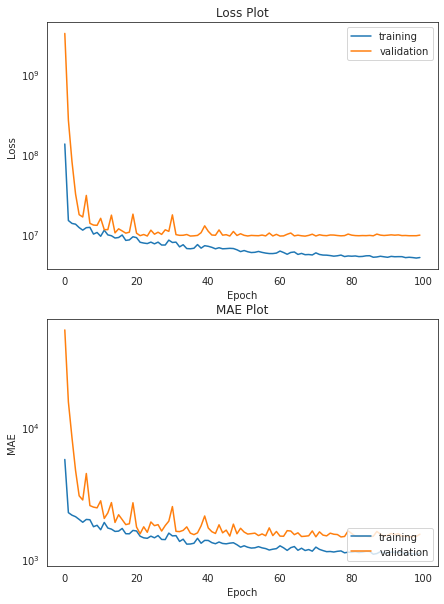

In [28]:
plot_loss_and_score(history)

### 4.2 Risultati sul Test Set

In [29]:
from sklearn.metrics import mean_absolute_error, r2_score

y_pred = model.predict(X_test)
score_r2 = r2_score(y_test, y_pred)
score_mae = mean_absolute_error(y_test, y_pred)
print('Results on test set:')
print('R2: ', round(score_r2,4))
print('MAE: ', round(score_mae))

Results on test set:
R2:  0.9807
MAE:  1563


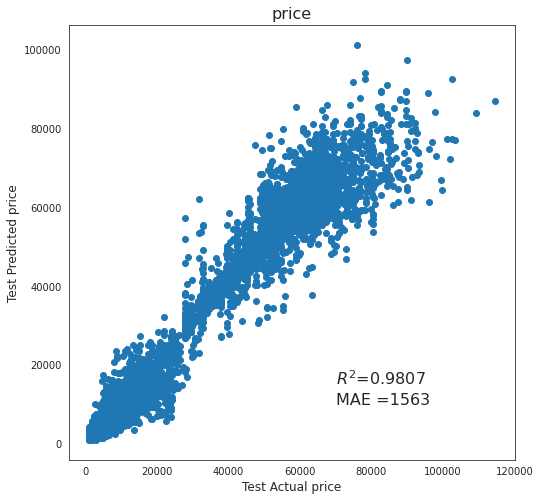

In [30]:
fig,ax = plt.subplots(figsize=(8,8))
ax.set_title("price",fontsize=16)
ax.set_ylabel('Test Predicted price',fontsize=12)
ax.set_xlabel('Test Actual price',fontsize=12)
ax.scatter(y_test,y_pred)

plt.text(70000,15000,'$ R^{2} $=' + str(round(score_r2, 4)), fontsize=16)
plt.text(70000,10000,'MAE =' + str(round(score_mae)), fontsize=16)
plt.show()

Si osserva che lo score ottenuto usando 1/3 dei dati è già comparabile al risultato ottenuto dal team che ha utilizzato ensemble di modelli classici.  
Eseguendo diverse run e esplorando lo spazio degli iperparametri si può migliorare ancora questo score.  
Inoltre bisogna anche vedere quanto migliora la performance della rete usando tutti i dati (in locale).  
Di seguito si mostra uno screenshot dei risultati ottenuti dal team con modelli classici.

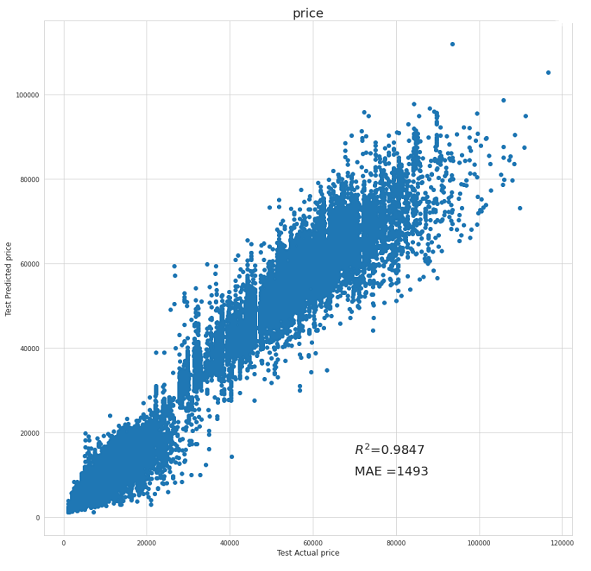

### 4.3 Plot degli score per diverse run singole (diversi iperparametri)
In questa sezione vengono importati dei file con gli score ottenuti dall'addestramento della rete con diversi valori degli iperparametri in modo da scegliere la combinazione migliore.

In [31]:
df_uniform = pd.read_excel('../input/valori-scores/Valori_score_uniform.ods',engine='odf')
df_lecun_uniform = pd.read_excel('../input/valori-scores/Valori_score_lecun_uniform.ods',engine='odf')
df_normal = pd.read_excel('../input/valori-scores/Valori_score_normal.ods',engine='odf')
#display(df_uniform)

In [32]:
print(df_uniform['batch_size'].unique())

[ 256  512 1024 2048]


In [33]:
from matplotlib import pyplot

In [34]:
def plot_score_vs_lr_for_different_init_weights(df_scores):
    plt.figure(figsize=(25,5))
    
    df_select = df_scores[df_scores['batch_size']==512]
    plt.subplot(1,3,1)
    x=df_select['learning_rate']
    y=df_select['score']
    plt.scatter(x,y)
    plt.xlabel('learning_rate')
    plt.ylabel('val_mae')
    pyplot.yscale('log')
    plt.title('Batch Size = 512')
    
    df_select=df_scores[df_scores['batch_size']==1024]
    plt.subplot(1,3,2)
    x=df_select['learning_rate']
    y=df_select['score']
    plt.scatter(x,y)
    plt.xlabel('learning_rate')
    plt.ylabel('val_mae')
    pyplot.yscale('log')
    plt.title('Batch Size = 1024')
    
    df_select=df_scores[df_scores['batch_size']==2048]
    plt.subplot(1,3,3)
    x=df_select['learning_rate']
    y=df_select['score']
    plt.scatter(x,y)
    plt.xlabel('learning_rate')
    plt.ylabel('val_mae')
    pyplot.yscale('log')
    plt.title('Batch Size = 2048')

--- Results Initializing Weights with Uniform Distribution ---


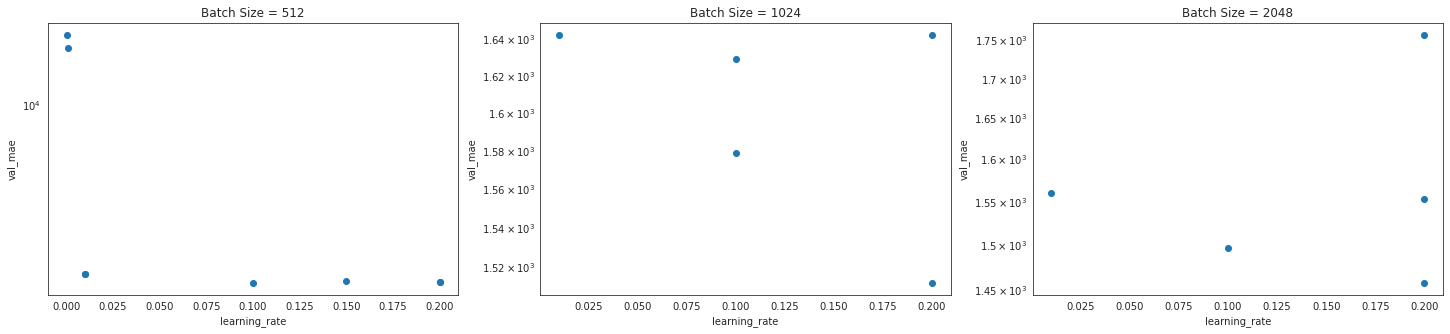

In [35]:
print('--- Results Initializing Weights with Uniform Distribution ---')
plot_score_vs_lr_for_different_init_weights(df_uniform)

--- Results Initializing Weights with Lecun-Uniform Distribution ---


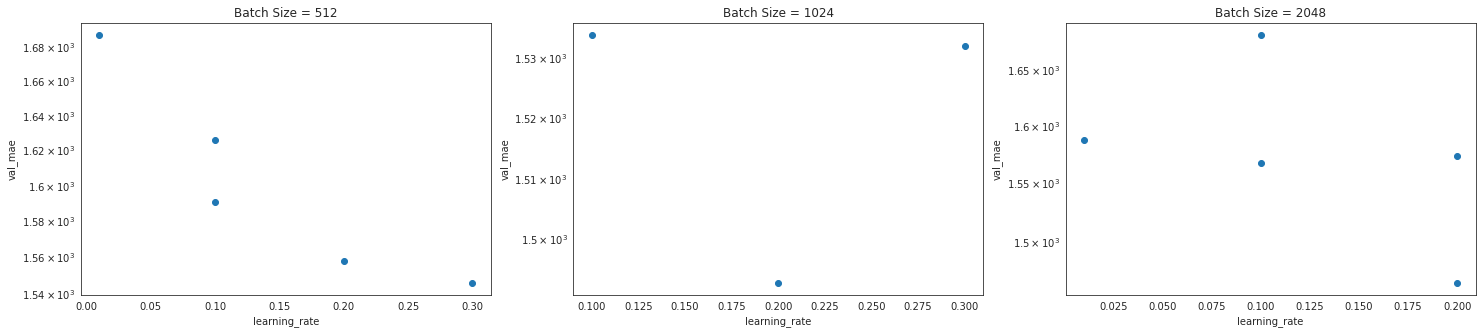

In [36]:
print('--- Results Initializing Weights with Lecun-Uniform Distribution ---')
plot_score_vs_lr_for_different_init_weights(df_lecun_uniform)

--- Results Initializing Weights with Normal Distribution ---


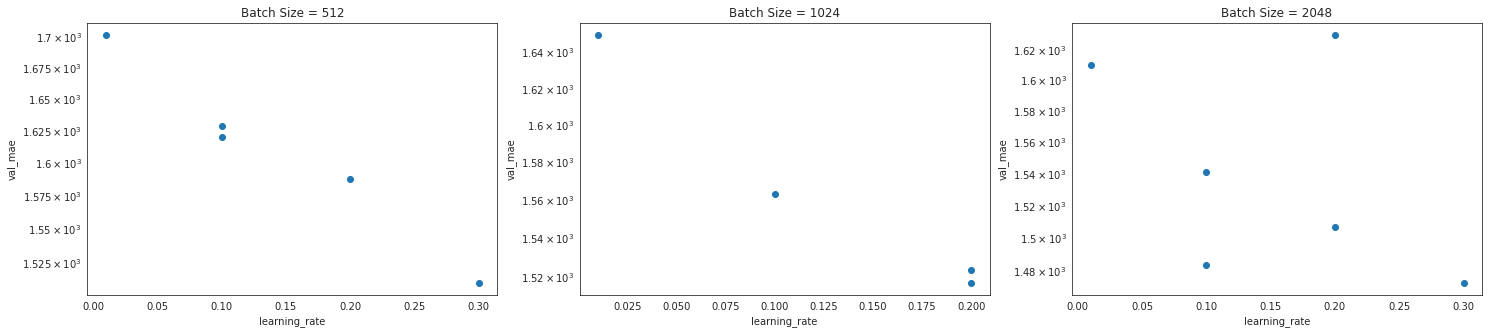

In [37]:
print('--- Results Initializing Weights with Normal Distribution ---')
plot_score_vs_lr_for_different_init_weights(df_normal)

Dall'ottimizzazione a mano, effettuata su un diverso numero di epoche (per quello qualche volta vi sono più punti per un singolo valore di learning rate), si osserva in generale che aumentando il learning rate e la batch size gli score mae di validation tendono ad abbassarsi.  
Questo da un idea di dove concentrare la ricerca degli iperparametri migliori nella prossima sezione di ottimizzazione automatica, dove si esploreranno learning rate più alti.

### 4.4 Ottimizzazione automatica con Keras Tuner
Si definisce il modello con gli iperparametri da ottimizzare. Nello studio condotto con tutti dati è stato direttamente usato questo metodo saltando quello manuale.
Si è osservato che avere un grande learning rate, grande batch size e molte epoche per addestrare il modello aiuta nel migliorare lo score.

In [38]:
import keras_tuner as kt

In [39]:
class RegressionHyperModel(kt.HyperModel):
    
    def init(self, input_shape):
        self.input_shape = input_shape
    
    def build(self, hp):
        # hprm: learning rate
        hp_learning_rate = hp.Choice('learning_rate',values=[0.2,0.3,0.4,0.5])
        

        # hprm: dropout
        #hp_dropout = hp.Choice('dropout', values=[0.10, 0.15, 0.20, 0.25])
        
        # hprm: regularizer
        values_array = np.logspace(-4, 0, num=5) #1e-4 till 1e-0 --> 0.0001, 0.001, 0.01, 0.1, 1
        values = values_array.tolist()
        hp_reg = hp.Choice('reg', values=values, default = 0.01)
        #hp_reg = 1e-5
        
        # hprm: init weights
        # init_weights: ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
        hp_init_weights = 'uniform'
        #hp_init_weights=hp.Choice('init_weights',values=init_weights, default='uniform')
        
        model = Sequential(
            [
                Input(input_shape),
                
                Dense(256, activation = 'relu',
                      kernel_initializer = hp_init_weights,
                      kernel_regularizer = l2(hp_reg)),
                
                BatchNormalization(),
                Dense(128, activation = 'relu',
                      kernel_initializer = hp_init_weights,
                      kernel_regularizer = l2(hp_reg)),
                
                BatchNormalization(),
                Dense(64, activation = 'relu',
                      kernel_initializer = hp_init_weights,
                      kernel_regularizer = l2(hp_reg)),
                
                Dense(1) # last layer is output
            ]
        )
        
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate = hp_learning_rate,
            decay_steps = 10000,
            decay_rate = hp_learning_rate / epochs
        )
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
        
        return model

    def fit(self, hp, model, *args, **kwargs):
        
        # hprm: batch size
        #hp_batch_size = hp.Choice('batch_size', values=[2048, 4096])
        hp_batch_size = 1024
        
        return model.fit(
            *args,
            batch_size = hp_batch_size,
            verbose=1,
            **kwargs,
        )

epochs = 100
input_shape = X_train.shape[1]
regr_hprm_model = RegressionHyperModel(input_shape)

In [40]:
tuner_rs = kt.RandomSearch(
    regr_hprm_model,
    objective='val_mae',
    max_trials=3,
    seed=1,
    overwrite=True,
    directory='my_dir',
    project_name='tune_hypermodel'
)
tuner_rs.search_space_summary()

Search space summary
Default search space size: 2
learning_rate (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.4, 0.5], 'ordered': True}
reg (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.0001, 0.001, 0.01, 0.1, 1.0], 'ordered': True}


In [41]:
tuner_rs.search(X_train_vald, y_train_vald, epochs=epochs, validation_split=0.2)

Trial 3 Complete [00h 00m 52s]
val_mae: 1443.950927734375

Best val_mae So Far: 1442.2392578125
Total elapsed time: 00h 03m 08s


In [42]:
best_hps= tuner_rs.get_best_hyperparameters()[0]
print(best_hps.values)

best_model = tuner_rs.get_best_models(num_models=1)[0]
best_model.summary()

{'learning_rate': 0.3, 'reg': 0.0001}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               394752    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 437,505
Trainable params: 436,737
Non-trainable params: 768
__________

In [43]:
summary = tuner_rs.results_summary(num_trials=3) # num_trials shows n best trials

Results summary
Results in my_dir/tune_hypermodel
Showing 3 best trials
Trial summary
Hyperparameters:
learning_rate: 0.3
reg: 0.0001
Score: 1442.2392578125
Trial summary
Hyperparameters:
learning_rate: 0.4
reg: 1.0
Score: 1443.950927734375
Trial summary
Hyperparameters:
learning_rate: 0.3
reg: 0.001
Score: 1472.2940673828125


# 5. Score finali
In questa ultima sezione si discutono i risultati finali ottenuti addestrando la rete con meno dati e quella addestrata con tutti i dati.  
Grazie a keras tuner si è esplorato lo spazio di iperparametri dato dai learning rate e dal coefficiente di regolarizzazione L2. Si è giunti alla conclusione che il **modello migliore allenato su 1/3 dei dati** è quello con:
- learning_rate = 0.3
- reg = 1.0  

che hanno portato ad uno score di validazione:
- $ R^2 = 0.9829 $
- $ MAE = 1411 $

Poi si sono usati questi valori per addestrare la **rete con tutti i dati** (rnd_state=1 in train test split) e lo score di validazione (48025 samples su 300153) ottenuto (aggiungendo anche il dropout al 10%) è stato:
- $ R^2_{vald} = 0.9856 $
- $ MAE_{vald} = 1328 $

mentre lo score di testing (60031 samples su 300153) è stato:
- $ R^2_{test} = 0.9862 $
- $ MAE_{test} = 1308 $

Si sono provati altri iperparametri per il modello allenato sul dataset completo e si è ottenuta performance migliore con gli iperparametri
- learning_rate = 0.2
- reg = 0.01

Nelle seguenti celle si importa il modello salvato in locale e il dataset di testing.

In [44]:
# comando da usare solo in locale per salvare i modelli visto che kaggle è read-only
#best_model.save('../input/saved-models/best_model_less_data')

In [45]:
# importare il modello migliore ottenuto in locale addestrandolo su tutti i dati
imported_model = tf.keras.models.load_model('../input/best-model-full-data/model_lr02_bs2048_reg0.01')

Il modello in locale è stato addestrato su tutti i dati ed è stato salvato in modo da poterlo importare su kaggle e per mostrare il risultato di questi modelli si importano direttamente i test set riferito al dataset completo.

In [46]:
df_X_test = pd.read_csv('../input/test-set-alldata/df_X_test.csv')
df_y_test = pd.read_csv('../input/test-set-alldata/df_y_test.csv')

df_X_test = df_X_test.drop(columns=['Unnamed: 0'])
df_y_test = df_y_test.drop(columns=['Unnamed: 0'])

In [47]:
X_Test = df_X_test.to_numpy()
y_Test = df_y_test.to_numpy()

In [48]:
y_pred = imported_model.predict(X_Test)

In [49]:
score_r2 = r2_score(y_Test, y_pred)
score_mae = mean_absolute_error(y_Test, y_pred)
print('Results on test set (full data):')
print('R2: ', round(score_r2,4))
print('MAE: ', round(score_mae))

Results on test set (full data):
R2:  0.9865
MAE:  1262


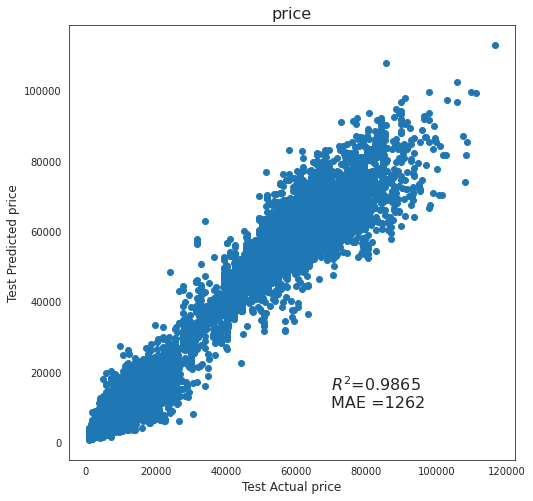

In [50]:
fig,ax = plt.subplots(figsize=(8,8))
ax.set_title("price",fontsize=16)
ax.set_ylabel('Test Predicted price',fontsize=12)
ax.set_xlabel('Test Actual price',fontsize=12)
ax.scatter(y_Test,y_pred)

score_r2 = r2_score(y_Test, y_pred) 
score_mae = mean_absolute_error(y_Test, y_pred)
plt.text(70000,15000,'$ R^{2} $=' + str(round(score_r2, 4)), fontsize=16)
plt.text(70000,10000,'MAE =' + str(round(score_mae)), fontsize=16)
plt.show()

### Conclusioni
Con questo ultimo modello si è riusciti ad ottenere uno score migliore di tutti quelli precedenti sia dal punto di vista del coefficiente di determinazione che del mean absolute error, battendo quindi anche i modelli classici passando da un MAE di 1492 a 1262, ovvero circa il 18% in meno. Questo risultato è importante e si ritiene sia dovuto alla maggiore prestabilità delle reti (rispetto a modelli classici) a problemi dove vi sono molti samples a disposizione per fare learning.  
Osservando il grafico Test Predicted price vs. Test Actual price del modello migliore e quello finale di (https://www.kaggle.com/code/julienjta/flight-price-prediction-98-47-r2-score) si vede anche come le predizioni siano meno sparse rispetto alla bisettrice.